## Clustering

In [1]:
from sklearn import cluster

Clustering of unlabeled data can be performed with the module sklearn.cluster.

Each clustering algorithm comes in two variants: a class, that implements the `fit` method to learn the clusters on train data, and a function, that, given train data, returns an array of integer labels corresponding to the different clusters. For the class, the labels over the training data can be found in the `labels_` attribute.

> source: https://scikit-learn.org/stable/modules/clustering.html


```python
km = cluster.KMeans(n_clusters = 13, n_jobs = 4, random_state=21)
km.fit(X)
km.labels_
```

### 2 variants

1. tries to find a pre-specified number of clusters
2. attempts to assign data to clusters based on distance metrics

In [28]:
import time
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
def plot_m():
    plt.figure(figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    plot_num = 1

    default_base = {'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1}

    datasets = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                         'quantile': .2, 'n_clusters': 2,
                         'min_samples': 20, 'xi': 0.25}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2,
                  'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
        (aniso, {'eps': .15, 'n_neighbors': 2,
                 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
        (blobs, {}),
        (no_structure, {})]

    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=params['n_neighbors'], include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # ============
        # Create cluster objects
        # ============
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
        ward = cluster.AgglomerativeClustering(
            n_clusters=params['n_clusters'], linkage='ward',
            connectivity=connectivity)
        spectral = cluster.SpectralClustering(
            n_clusters=params['n_clusters'], eigen_solver='arpack',
            affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=params['eps'])

        affinity_propagation = cluster.AffinityPropagation(
            damping=params['damping'], preference=params['preference'])
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average", affinity="cityblock",
            n_clusters=params['n_clusters'], connectivity=connectivity)
        birch = cluster.Birch(n_clusters=params['n_clusters'])
        gmm = mixture.GaussianMixture(
            n_components=params['n_clusters'], covariance_type='full')

        clustering_algorithms = (
            ('MiniBatchKMeans', two_means),
            ('AffinityPropagation', affinity_propagation),
            ('MeanShift', ms),
            ('SpectralClustering', spectral),
            ('Ward', ward),
            ('AgglomerativeClustering', average_linkage),
            ('DBSCAN', dbscan),
            ('Birch', birch),
            ('GaussianMixture', gmm)
    #                 ('OPTICS', optics),
    #             optics = cluster.OPTICS(min_samples=params['min_samples'],
    #                             xi=params['xi'],
    #                             min_cluster_size=params['min_cluster_size'])

        )

        for name, algorithm in clustering_algorithms:
            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the " +
                    "connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                algorithm.fit(X)

            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
            # add black color for outliers (if any)
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
            plot_num += 1
    return plt.show()

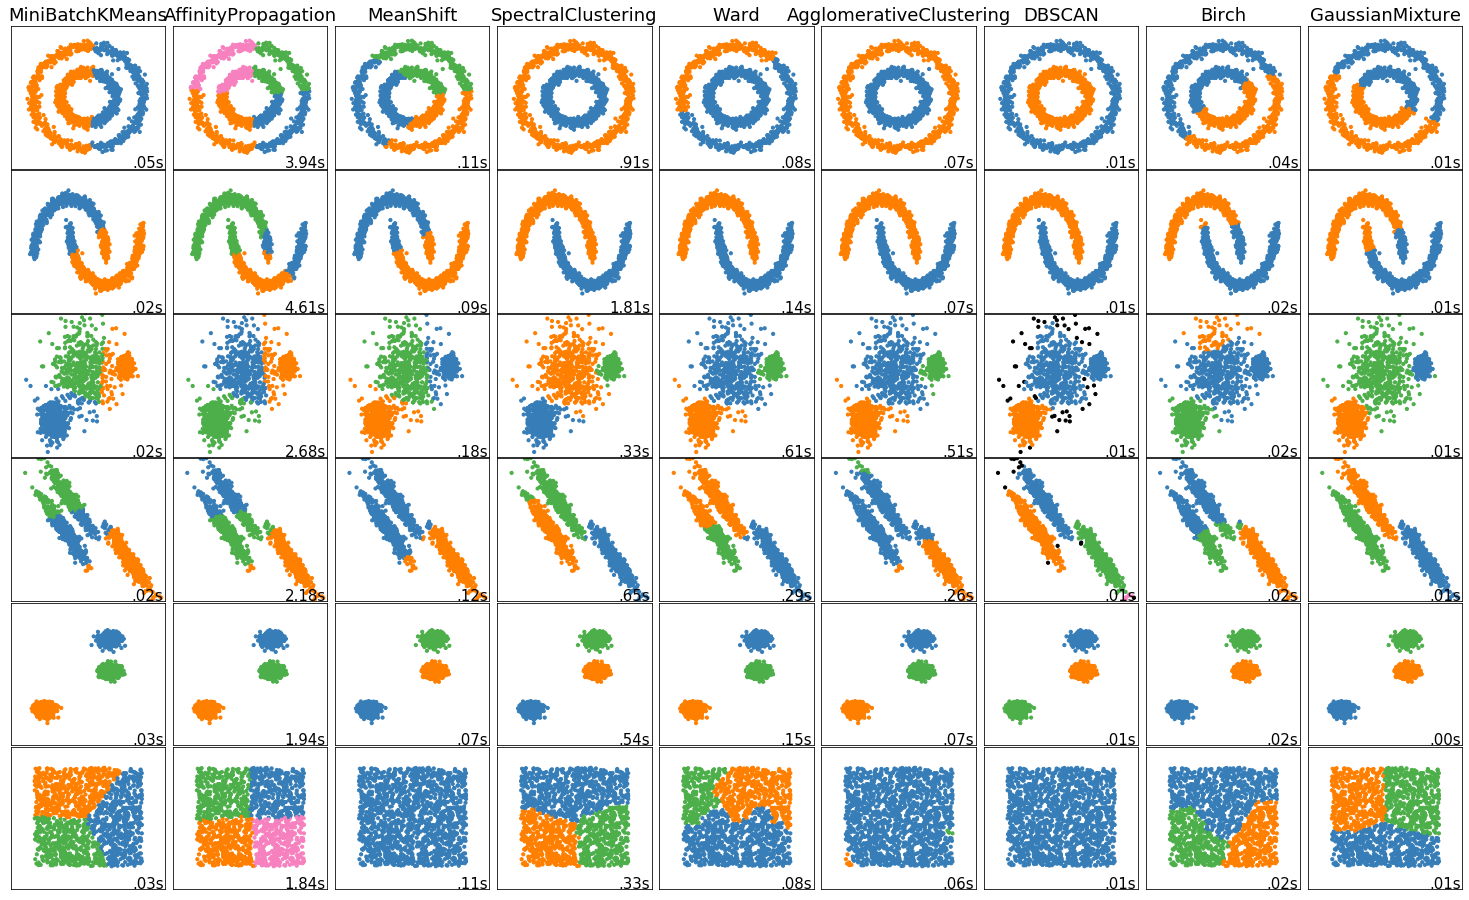

In [2]:
plot_m()

> source https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html


### Prespecified number of clusters

With Fishers Iris data set.

>The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis.[1] It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species.

> https://en.wikipedia.org/wiki/Iris_flower_data_set

In [3]:
import plotly.express as px
iris = px.data.iris()
iris.head(2)
# Alternative dataformat
# from sklearn import datasets
# iris = datasets.load_iris()

sepal_length  sepal_width  petal_length  petal_width species  species_id
0           5.1          3.5           1.4          0.2  setosa           1
1           4.9          3.0           1.4          0.2  setosa           1

In [4]:
px.scatter(iris, x="sepal_width", y="sepal_length",template="none")

### Go from pandas to numpy

In [5]:
X = iris.iloc[:, :4].values
X[:2,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

In [7]:
km = cluster.KMeans(n_clusters = 13, n_jobs = 4, random_state=21)
km.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=21, tol=0.0001, verbose=0)

#### Works fine as well

In [ ]:
km.fit(iris.iloc[:, :4])

### How do we determine the number of clusters?


In [8]:
import pandas as pd
x_iter = range(1, 11)
wcss = []

df = iris.copy()
df.loc[:,"iter"] = 0
df.loc[:,"labels"] = "0"

dnan = iris.copy()[:1]

dnan = pd.concat([dnan for x in x_iter])

for i in x_iter:
    dnan.loc[:,"iter"] = i
    dnan.loc[:,"labels"] = [str(x) for x in x_iter]
    dft = iris.copy()
    dft.loc[:,"iter"] = i
    kmeans = cluster.KMeans(n_clusters = i, init = X[:i,], max_iter = 300, random_state = 22, n_init=1)
    kmeans.fit(X)
    dft.loc[:,"labels"] = kmeans.labels_.astype("str")
    df = pd.concat([df,dft,dnan],axis=0)
    wcss.append(kmeans.inertia_)
    
df.loc[:,"labels"] = df["labels"].astype("category")

In [9]:
df=df.query('iter!=0')

In [11]:
fig = px.scatter(
    df,
    x="sepal_width", 
    y="sepal_length", 
    animation_frame="iter",
    color = "labels"
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500
fig.layout.update(showlegend=False)
fig.show()

In [12]:
wcss = []
x = range(1, 11)
for i in x:
    kmeans = cluster.KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 22)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

px.line(x=x, 
        y=wcss, 
        template = "none", 
        labels={"x":"Number of clusters", "y":"Within Cluster sum of squares"},
        title="Elbow method, knæ-metoden, kink in the curve"
       )

In [13]:
kmeans = cluster.KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 22)
kmeans.fit(X)
iris["clusters"] = kmeans.labels_.astype("str")
px.scatter(iris, x="sepal_width", y="sepal_length",template="none",color="clusters")

### Examine clusters

Allows to examine the spread of each true cluster across predicted clusters and vice versa.

The contingency table calculated is typically utilized in the calculation of a similarity statistic (like the others listed in this document) between the two clusterings.

In [23]:
from sklearn.metrics.cluster import contingency_matrix
x = iris.species
y = kmeans.labels_
contingency_matrix(x, y)

array([[ 0, 50,  0],
       [ 2,  0, 48],
       [36,  0, 14]])

### The Silhouette Coefficient

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient $s$ for a single sample is then given as:

$$
s = \frac{b - a}{max(a, b)}
$$

The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

#### Drawbacks
The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [29]:
from sklearn import metrics
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.5525919445499757

#### Clustering used for image compression

<img src="./../greyscale0.png" width="200" style='margin: 0px; float: left; border: 1px solid black;'><img src="./../greyscale.png" width="200" style='margin: 0px; float: left; border: 1px solid black;'>
<img src="./../greyscale1.png" width="200" style='margin: 0px; float: left; border: 1px solid black;'> 

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
Sir Ronald A. Fisher (1890 − 1962) was one of the founders
of modern day statistics, to whom we owe maximum-likelihood, sufficiency, and
many other fundamental concepts. The image on the left is a 1024×1024 grayscale
image at 8 bits per pixel. The center image is the result of 2 × 2 block VQ, using
200 code vectors, with a compression rate of 1.9 bits/pixel. The right image uses
only four code vectors, with a compression rate of 0.50 bits/pixel

### Exercise



1. Combine the data from the 2 branin dataset and perform clustering on the points in $\mathbb{R}^2$
2. Try to determine number of clusters with the elbow method
3. If time look at the distribution of the variables and make adjustments acordingly

Use the following if you want to plot the points
```python
X["clusters"] = -1
X.loc[X.loc[:,"pwi"]!=0,"clusters"] = kmeans.labels_
plot_vals = X.clusters.values.reshape(pwi.shape)
```

## No prespecified number of clusters

Exampel DBSCAN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/800px-DBSCAN-Illustration.svg.png">

- A point $p$ is a core point if at least `minPts` points are within distance $\epsilon$ of it (including $p$).
- A point $q$ is directly reachable from $p$ if point $q$ is within distance $\epsilon$ from core point $p$. Points are only said to be directly reachable from core points.
- A point $q$ is reachable from $p$ if there is a path $p_1$, ..., $p_n$ with $p_1 = p$ and $p_n = q$, where each $p_{i+1}$ is directly reachable from $p_i$. Note that this implies that all points on the path must be core points, with the possible exception of $q$.
All points not reachable from any other point are outliers or noise points.

In this diagram, `minPts` = 4. Point A and the other red points are core points, because the area surrounding these points in an $\epsilon$ radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=0.4, min_samples=6).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [15]:
iris["clusters"] = labels.astype("str")
iris["core"] = "Noise"
iris.loc[db.core_sample_indices_,"core"] = "Core"
px.scatter(iris,
           x="sepal_width",
           y="sepal_length",facet_col="core",
           template="none",color="clusters")

In [16]:
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]

X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

In [17]:
blobs = pd.DataFrame(data=X,columns=["x1","x2"])
blobs.head()

x1        x2
0  0.840220  1.148022
1 -1.154748 -1.204117
2  0.678636  0.724180
3  0.450783 -1.427097
4  1.492116  1.480952

In [20]:
import pandas as pd
x_iter = range(1, 11)
wcss = []

df = blobs.copy()
df.loc[:,"eps"] = 0
df.loc[:,"iter"] = "0"
df.loc[:,"labels"] = "0"

dnan = blobs.copy()[:1]

dnan = pd.concat([dnan for x in range(-1,17)])

for i in x_iter:
    dnan.loc[:,"eps"] = 1/i
    dnan.loc[:,"iter"] = str(i)
    dnan.loc[:,"labels"] = [str(x) for x in range(-1,17)]
    
    dft = blobs.copy()
    dft.loc[:,"eps"] = 1/i
    dft.loc[:,"iter"] = str(i)
    db = DBSCAN(eps=1/i, min_samples=6).fit(X)
    dft.loc[:,"labels"] = db.labels_.astype("str")
    
    df = pd.concat([df,dft,dnan],axis=0) 


In [21]:
df=df.query('eps!=0')
fig = px.scatter(
    df,
    x="x1", 
    y="x2", 
    animation_frame="eps", #     animation_group="eps",
    color = "labels",
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.layout.update(showlegend=False)
fig.show()

### Exercise

### DBSCAN on danish housing coordinates


1. Visualize the given data
2. Try to cluster the points with $\epsilon= \frac{1}{11}$

Experiment with different values of $\epsilon$ and vizulaize the outcome, note the development of the cluster `-1`

## Soft clustering

### Guassian Mixture models

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.


> soruce https://scikit-learn.org/stable/modules/mixture.html#mixture

<img src="./../respons.PNG"> 

In [29]:
from sklearn import mixture

X_t, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(X_t)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [30]:
# display predicted scores by the model as a contour plot
x = np.linspace(-2.5, 2.5)
y = np.linspace(-2.5, 2.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = clf.score_samples(XX) ## Log probabilities for each sample
Z = Z.reshape(X.shape)

In [31]:
def plot_mesh(prob):
    fig = go.Figure(
        data=[
            go.Contour(
                x=x,
                y=y,
                z=prob,
            colorscale='Viridis'
            ),
            go.Scattergl(
                x = X_t[:,0],
                y = X_t[:,1],
                mode = 'markers',
                marker = dict(
                    line = dict(
                        width = 1,
                        color = 'DarkSlateGrey')
                )
            )
        ]
    )
    return fig

In [32]:
plot_mesh(Z)

In [33]:
Z = clf.predict_proba(XX)[:,0] # Responsibilities for 
Z = Z.reshape(X.shape)
plot_mesh(Z)

### Extra opgave

Sammenlign K-means fra tidligere med Gaussian mixture models for hjerne datasættet.


## Matematisk udledning

Det er svært at specificere fordelingen tilhørende de observerede variable, $ p(x), \; x\in \mathbb{R} $. Vi tager en multinomial fordelings tilgang og definerer istedet latente variable $ z = (z_1,...,z_k) $ så $ z_k \in \{0,1 \} $ og $ \sum_{k}z_k=1 $. Sæt $ \pi_k:=p(z_k=1) $

$$
\begin{align*}
p(z) &= \prod_{k=1}^{K}\pi_k^{z_k} \\
p(x|z) &= \prod_{k=1}^{K} \mathcal{N}(x|\mu_k, \sigma_k)^{z_k} \\
p(x) &= \sum_z p(z)p(x|z)= \sum_z \prod_{k=1}^{K} \pi_k^{z_k} \mathcal{N}(x|\mu_k, \sigma_k)^{z_k} = \sum_{k=1}^{K}\pi_k \mathcal{N}(x|\mu_k, \sigma_k)
\end{align*}
$$

Vi gør os altså istedet antagelser om fordelingen af x givet de latente variable som skal ses som en antagelse om $ x $'ernes underliggende struktur. Men løst sagt så slipper vi ikke for at specificere hvilken fordeling som genererer støjen omkring $ z_k $'erne som resulterer i de observérbare $ x $'er, vi tager blot en rute som sikrer at vi får en opdeling med $ k  $ dele.

Mixture of Gaussians tillader os at arbejde med en generativ model/description af $ p(x) $ gennem de latente variable $ z $ 


$$
\begin{align*}
p(z_k=1| x) &= \frac{p(z_k=1, x)}{p(x)} =  \frac{p(z_k=1)p(x|z_k=1)}{\sum_{j=1}^{K}p(z_j=1)p(x|z_j=1)}
\\&= \frac{\pi_k \mathcal{N}(x|\mu_k, \sigma_k^2)}{\sum_{j=1}^{K}\pi_j \mathcal{N}(x|\mu_j, \sigma_j^2) }
\end{align*}
$$


## Maximum Likelihood Estimation

Antag $ x=(x_1,...,x_N), \; x_i \in \mathbb{R} $. 

Lad de diskrete latente variable $ z=(z_1,..,z_N), \; z_j \in \mathbb{R}^K $, latente variable i høj-dimensionelt rum?

$$
\begin{align*}
\log \text{likelihood} &=\ln p(x|\pi,\mu,\sigma^2) = \sum_{n=1}^{N}\ln \left\lbrace \sum_{k=1}^{K} \pi_k \mathcal{N}(x|\mu_k, \sigma_k) \right\rbrace 
\end{align*}
$$
Differentier mht. $ \mu_k $
$$
\begin{align*}
\frac{d \log \text{likelihood} }{d\mu_k}&= \sum_{n=1}^N \frac{\pi_k \mathcal{N}(x|\mu_k, \sigma_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}(x|\mu_k, \sigma_k)}\frac{1}{\sigma^2}(x_n-\mu_k) \\
&=\sum_{n=1}^N \gamma(z_{nk}) \frac{1}{\sigma^2}(x_n-\mu_k) \\
\end{align*}
$$
Dette medfører}
$$
\begin{align*}
\hat{\mu}_k &= \frac{1}{\sum_{n=1}^N \gamma(z_{nk})}\sum_{n=1}^N \gamma(z_{nk})x_n =\frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk})x_n
\end{align*}
$$

$ N_k =\sum_{n=1}^N \gamma(z_{nk})$. Tilsvarende fås

$$
\begin{align*}
\hat{\sigma}^2&=\frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk})(x_n-\mu_k)^2
\end{align*}
$$
Ved længere udregning fås
$$
\begin{align*}
\hat{\pi}_k &= \frac{N_k}{N}
\end{align*}
$$

### Algoritme

Bygger på Expectation maximization  

- Initialisér $ \hat{\pi},\hat{\mu},\hat{\sigma}^2 $
- Expectation step [E-step]: Udregn responsibilities
$$
\begin{equation}
\hat{\gamma}(z_{nk})=\frac{\hat{\pi}_k \mathcal{N}(x|\hat{\mu}_k, \hat{\sigma}_k)}{\sum_{j=1}^{K}\hat{\pi}_j\mathcal{N}(x|\hat{\mu}_k, \hat{\sigma}_k)}, \quad n=1,...,N
\end{equation}
$$
- Maksimerings steppet [M-step]: Udregn nye ustimater for $ \hat{\pi},\hat{\mu},\hat{\sigma}^2 $
$$
\begin{align*}
\hat{\mu}_k &= \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk})x_n \\
\hat{\sigma}^2&=\frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk})(x_n-\mu_k)^2 \\
\hat{\pi}_k &= \frac{N_k}{N}
\end{align*}
$$


### Appendix


In [74]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"

fig = make_subplots(rows=2,cols=1)

fig.add_trace(
    go.Scatter(x=iris[core_samples_mask].sepal_width,
               y=iris[core_samples_mask].sepal_length,
               marker=dict(color=labels[core_samples_mask]),
               mode='markers',name='core points'),
    row=1, col=1)

fig.add_trace(go.Scatter(x=iris[~core_samples_mask].sepal_width, 
                         y=iris[~core_samples_mask].sepal_length,
                         marker=dict(color=labels[~core_samples_mask]),
                         mode='markers',name='noise'),
              row=2,col=1)